### Preprocessing

In [1]:
# Import packages
import os
os.chdir("../src/preprocessing") # Change current working directory to load preprocessing functions
#from create_embedding import _load_model, preprocess_folder, apply_embedding_model_to_svgs, combine_embeddings, encode_pkl, encode_svg, decode_z
from create_svg_embedding import _load_model, apply_embedding_model_to_svgs, combine_embeddings, encode_svg, decode_z
from deepsvg.svglib.svg import SVG
from deepsvg import utils
os.chdir("../..")

In [2]:
from src.data.insert_ids import insert_ids_in_folder
from src.data.rename_logos import rename_logos
from src.data.get_svg_meta_data import get_svg_meta_data
from src.data.generate_random_animations import random_animation_vector
from src.data.expand_viewbox import expand_viewbox_in_folder
from src.preprocessing.sort_paths import sort_by_relevance
from src.preprocessing.decompose_logo import decompose_logos_in_folder
from src.features.get_style_attributes import *
#from src.features.get_style_attributes_folder import get_local_style_attributes, get_global_style_attributes, combine_style_attributes
from src.models_output.insert_animation import create_animated_svg
from src.models_output.transform_animation_predictor_output import transform_animation_predictor_output
import pandas as pd
import numpy as np
import importlib, glob, pickle, torch, logging
from datetime import datetime
from concurrent import futures
from tqdm import tqdm

In [3]:
#file = "data/decomposed_svgs/L_Sonja_1_0.svg"
#file = "data/decomposed_svgs/L_Sonja_5_10.svg"
file = "data/decomposed_svgs/L_7sins_01_0.svg"
z = encode_svg(filename = file, data_folder="data/decomposed_svgs")

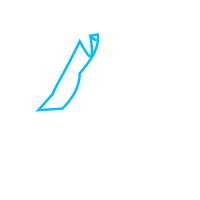

In [13]:
decode_z(z,
             model_path="models/hierarchical_ordered.pth.tar",
             cfg_module="configs.deepsvg.hierarchical_ordered",
             data_folder="data/decomposed_svgs",
             do_display=True,
             return_svg=False,
             return_png=False)

#### 1 Rename and insert IDs in SVGs
Logos are renamed and an ID called animation_id is inserted for every path in a SVG.

In [8]:
expand_viewbox_in_folder('data/initial_svgs', 50, "data/svgs_expanded")

In [3]:
rename_logos("data/svgs_expanded", "data/svgs_expanded_renamed")

In [4]:
insert_ids_in_folder("data/svgs_expanded_renamed", "data/svgs")

#### 2 Decompose SVGs
Decompose SVGs by saving every path in a seperate SVG file. Decomposed SVGs are save to data/decomposed_svgs.

In [6]:
decompose_logos_in_folder("data/svgs")

#### 3 Simplify SVGs
Creates simplified SVGs and its tensors on SVG and path level  
UPDATE: NOT NEEDED ANYMORE

In [7]:
preprocess_folder(data_folder="data/svgs")

100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:54<00:00,  3.52it/s]


In [8]:
preprocess_folder(data_folder="data/decomposed_svgs")

100%|██████████████████████████████████████████████████████████████████████████████| 5109/5109 [02:42<00:00, 31.53it/s]


#### 4 Get SVGs Metadata

In [4]:
meta_data = get_svg_meta_data("data/svgs")
meta_data

100%|████████████████████████████████████████████████████████████████████████████████| 192/192 [00:07<00:00, 27.35it/s]


,id,total_len,nb_groups,len_groups,max_len_group,start_pos
0,logo_0,86,10,"[7, 7, 5, 4, 4, 7, 14, 16, 7, 15]",16,"[P(11.9639253616333, 4.5934014320373535), P(11..."
1,logo_1,114,8,"[7, 7, 8, 10, 23, 23, 15, 21]",23,"[P(8.111812591552734, 9.714151382446289), P(8...."
2,logo_10,112,13,"[11, 14, 11, 13, 9, 9, 11, 6, 6, 5, 6, 6, 5]",14,"[P(5.903238773345947, 10.45088005065918), P(12..."
3,logo_101,361,35,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 11, 11, 16, 21, 18...",32,"[P(11.995269775390625, 9.817630767822266), P(1..."
4,logo_100,372,30,"[120, 5, 5, 15, 5, 5, 13, 13, 8, 13, 13, 5, 11...",120,"[P(12.465529441833496, 8.196613311767578), P(9..."
...,...,...,...,...,...,...
187,logo_96,463,32,"[4, 27, 5, 5, 17, 19, 14, 19, 33, 13, 24, 19, ...",33,"[P(5.76159143447876, 9.227791786193848), P(4.5..."
188,logo_95,1205,41,"[81, 86, 56, 376, 11, 126, 17, 5, 5, 5, 10, 7,...",376,"[P(17.007122039794922, 7.569143772125244), P(1..."
189,logo_98,299,38,"[4, 5, 17, 5, 5, 5, 8, 6, 13, 17, 12, 12, 14, ...",17,"[P(6.667652130126953, 8.149038314819336), P(6...."
190,logo_97,294,37,"[5, 3, 17, 5, 5, 5, 8, 6, 17, 13, 12, 12, 14, ...",17,"[P(6.673834323883057, 9.33651351928711), P(8.7..."


In [5]:
output = open("data/svgs_metadata.pkl", 'wb')
pickle.dump(meta_data, output)
output.close()

#### 5 Get Path Embeddings
Apply hierarchical generative network to produce latent vector z

In [37]:
#model = "models/20210301_1813_model_batch60_epoch30_decomposed_svgs.pth.tar"
model = "models/hierarchical_ordered.pth.tar"

In [4]:
#svgs_embedding = apply_embedding_model_to_svgs(model_path=model, data_folder="data/svgs", save=False)

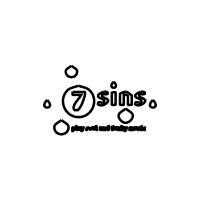

In [18]:
svg = SVG.load_svg("data/svgs/L_7sins_04.svg")
svg.fill_(False).normalize().zoom(0.9)
svg = svg.canonicalize().simplify_heuristic()
svg.draw()

In [3]:
a = apply_embedding_model_to_svgs(data_folder="data/decomposed_svgs", save=False)

  2%|█▌                                                                             | 105/5109 [00:04<04:16, 19.54it/s]

data/decomposed_svgs\logo_103_22.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 36 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


  7%|█████▌                                                                         | 360/5109 [00:12<02:48, 28.10it/s]

data/decomposed_svgs\logo_112_12.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 38 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


  8%|██████                                                                         | 389/5109 [00:14<03:04, 25.58it/s]

data/decomposed_svgs\logo_113_12.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 38 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


  8%|██████▍                                                                        | 415/5109 [00:15<04:32, 17.22it/s]

data/decomposed_svgs\logo_114_12.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 38 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 32%|████████████████████████▉                                                     | 1635/5109 [01:16<05:02, 11.48it/s]

data/decomposed_svgs\logo_175_0.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 46 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 32%|█████████████████████████                                                     | 1640/5109 [01:16<04:52, 11.84it/s]

data/decomposed_svgs\logo_175_11.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 32 and 70 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 32%|█████████████████████████▏                                                    | 1651/5109 [01:17<04:10, 13.80it/s]

data/decomposed_svgs\logo_175_3.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 80 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 32%|█████████████████████████▎                                                    | 1656/5109 [01:17<04:43, 12.19it/s]

data/decomposed_svgs\logo_175_4.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 80 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 32%|█████████████████████████▎                                                    | 1660/5109 [01:18<05:46,  9.97it/s]

data/decomposed_svgs\logo_175_8.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 40 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 33%|█████████████████████████▋                                                    | 1685/5109 [01:19<03:35, 15.90it/s]

data/decomposed_svgs\logo_177_10.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 34 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 33%|██████████████████████████                                                    | 1703/5109 [01:20<03:02, 18.62it/s]

data/decomposed_svgs\logo_177_5.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 34 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 66%|███████████████████████████████████████████████████▎                          | 3363/5109 [02:36<01:58, 14.69it/s]

data/decomposed_svgs\logo_37_0.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 34 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 70%|██████████████████████████████████████████████████████▋                       | 3578/5109 [02:47<01:27, 17.43it/s]

data/decomposed_svgs\logo_46_22.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 38 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 76%|███████████████████████████████████████████████████████████▎                  | 3882/5109 [03:02<01:57, 10.40it/s]

data/decomposed_svgs\logo_57_5.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 39 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


 96%|██████████████████████████████████████████████████████████████████████████▋   | 4893/5109 [03:53<00:11, 18.87it/s]

data/decomposed_svgs\logo_91_22.svg: Simplify failed invalid argument 0: Sizes of tensors must match except in dimension 0. Got 36 and 32 in dimension 1 at C:\w\1\s\windows\pytorch\aten\src\TH/generic/THTensor.cpp:612


100%|██████████████████████████████████████████████████████████████████████████████| 5109/5109 [04:05<00:00, 20.84it/s]


In [12]:
output = open("data/path_embedding.pkl", 'wb')
pickle.dump(a, output)
output.close()

In [11]:
len(a['filename'].unique())

192

In [ ]:
#combined_embedding = combine_embeddings(df_svg_embedding=svgs_embedding, df_decomposed_svg_embedding=decomposed_svgs_embedding, model_path=model, save=False)

In [9]:
decomposed_svgs_embedding

,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,L_7sins_01_10,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,L_7sins_01_11,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L_7sins_01_1,1,1.058049,-0.221425,1.557320,-0.180708,-1.182121,0.801264,0.992946,1.265655,...,-2.367993,-1.322433,-1.019614,-0.560317,0.006592,-0.656671,-0.971138,-1.833762,1.170980,0.299563
3,L_7sins_01_0,0,0.573274,-0.169635,1.547139,-0.351954,-0.938741,0.352232,0.770248,1.144378,...,-2.630614,-1.088127,-0.493820,-1.005420,0.040128,-0.295772,-0.682393,-1.680727,1.112269,-0.015597
4,L_7sins_01_14,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5076,L_Weidenbachhof_9_2_4,4,0.789945,0.071214,1.702776,-0.441861,-1.201321,0.604801,1.136409,1.076383,...,-2.226045,-1.005836,-0.615871,-0.403113,-0.045758,-0.361017,-0.315227,-1.989081,1.048624,0.578470
5077,L_Weidenbachhof_9_2_6,6,0.784052,0.049785,1.310274,-0.556812,-1.248168,1.086187,0.729777,1.235167,...,-1.918421,-1.250743,-0.621715,-0.353701,0.304269,-0.660002,-0.422328,-2.391057,1.110940,0.514435
5078,L_Weidenbachhof_9_2_7,7,1.056329,0.010147,1.486216,-0.541472,-1.205664,0.974453,0.917410,1.520458,...,-2.000242,-1.159243,-0.693862,-0.452490,0.158430,-0.778412,-0.669429,-2.013637,1.229304,0.485261
5079,L_Weidenbachhof_9_2_8,8,1.327888,-0.738074,1.614826,-0.129609,-1.069742,1.113564,1.060841,1.533815,...,-2.406755,-1.027968,-0.806419,-0.673152,-0.188934,-0.878584,-0.514161,-1.902013,1.157261,0.620449


In [6]:
#encode_svg("data/decomposed_svgs/L_7sins_01_0.svg", model_path=model, data_folder="data/decomposed_svgs")

#### 5 Get Style Attributes
Get local as well as global style attributes of SVGs.

In [7]:
df_local = get_local_style_attributes("data/svgs")
df_global = get_global_style_attributes("data/svgs")

In [8]:
df_all_style_attributes = combine_style_attributes(df_global, df_local)
df_all_style_attributes

,file,animation_id,class_,fill,stroke,stroke_width,opacity,stroke_opacity
0,L_7sins_01.svg,0,st0,#FABB00,#000000,0,1.0,1.0
1,L_7sins_01.svg,1,st1,#C5007B,#000000,0,1.0,1.0
2,L_7sins_01.svg,2,st2,#EC7404,#000000,0,1.0,1.0
3,L_7sins_01.svg,3,st1,#C5007B,#000000,0,1.0,1.0
4,L_7sins_01.svg,4,st2,#EC7404,#000000,0,1.0,1.0
...,...,...,...,...,...,...,...,...
5095,L_Weidenbachhof_9_2.svg,22,st3,#FFFFFF,#000000,0,1.0,1.0
5096,L_Weidenbachhof_9_2.svg,23,st3,#FFFFFF,#000000,0,1.0,1.0
5097,L_Weidenbachhof_9_2.svg,24,st3,#FFFFFF,#000000,0,1.0,1.0
5098,L_Weidenbachhof_9_2.svg,25,st3,#FFFFFF,#000000,0,1.0,1.0


In [ ]:
#df_all_style_attributes.to_csv("data/style_attributes.csv")

In [ ]:
#output = open("data/style_attributes.pkl", 'wb')
#pickle.dump(df_all_style_attributes, output)
#output.close()

#### 6 Insert Animations

In [5]:
file = "data/svgs/L_7sins_02.svg"
animation_id = sort_by_relevance("data/path_selection/L_7sins_02")

In [6]:
for s in range(200):
    model_output = random_animation_vector(8, seed=s)
    create_animated_svg(file, animation_id, model_output, str(s))

In [5]:
with open('data/path_embedding.pkl', 'rb') as f:
    svgs_embedding = pickle.load(f)

#svgs_embedding[svgs_embedding['filename'] == f"{logo_name}"]

In [6]:
svgs_embedding#.dropna()

,filename,animation_id,0,1,2,3,4,5,6,7,...,246,247,248,249,250,251,252,253,254,255
0,L_7sins_01,0,0.528078,-0.821644,-0.122652,1.411909,-0.655937,1.278711,-0.606417,-1.533502,...,-0.229828,-0.810564,0.419082,-0.331659,0.091425,-1.093283,-1.394454,0.818913,-0.578239,-0.090547
1,L_7sins_01,1,1.274369,-2.215594,0.418359,0.322488,0.543223,0.864393,-0.773602,-1.031192,...,-0.856521,-2.083487,0.715938,1.431139,0.320074,-1.069192,-0.150538,0.768586,0.159383,-0.829308
8,L_7sins_01,3,1.379206,-1.854066,0.611372,0.672185,0.402664,1.554239,-0.366231,-0.733832,...,0.311397,-2.273414,0.038978,2.380411,0.803548,-0.861410,-0.408416,-0.068678,0.933381,-0.879638
9,L_7sins_01,2,0.472991,-1.226775,1.533987,-0.424805,-0.669460,1.127602,-0.713290,-0.084230,...,-1.234275,-2.134554,0.293492,1.386334,0.820009,-1.371945,-0.019476,-0.042061,0.339579,0.314696
10,L_7sins_01,4,1.223025,-1.810805,1.154082,1.085018,-0.081046,1.394158,-1.343777,-0.989737,...,-0.258803,-1.559884,-0.182104,0.341202,0.294003,-1.128353,-0.782518,-0.008047,-0.622554,-0.243537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982,L_Weidenbachhof_9_2,5,1.420508,0.284751,1.306004,-0.239025,-0.600043,-1.303397,-0.727595,0.684894,...,0.050360,-3.857002,-0.576333,1.011679,0.867470,-1.261334,-1.125669,-1.123603,1.967078,1.598536
4983,L_Weidenbachhof_9_2,6,0.218143,-1.502262,1.006997,-0.218282,0.062004,0.051366,-2.292396,0.426296,...,-2.013161,-3.315885,-0.143858,1.519482,1.645396,-1.084207,-0.555623,-0.318483,-0.063448,1.268676
4984,L_Weidenbachhof_9_2,8,0.861285,-1.686104,1.262487,-1.128223,-0.187294,0.017669,-1.747269,-0.196984,...,-2.422992,-4.705516,0.285818,1.774886,1.593126,-1.800894,-0.586864,-0.000774,0.200038,0.794936
4985,L_Weidenbachhof_9_2,7,0.234749,-0.915931,1.484314,-0.272840,0.099517,-1.041811,-2.000403,0.361636,...,-1.541775,-3.713866,0.388559,1.408807,1.181244,-0.996578,-0.816932,-0.815901,0.835977,1.768944


In [20]:
svgs_embedding['filename'].apply(lambda row: row.split('_')[0:-1])

0                  [L, 7sins]
1                  [L, 7sins]
8                  [L, 7sins]
9                  [L, 7sins]
10                 [L, 7sins]
                ...          
4982    [L, Weidenbachhof, 9]
4983    [L, Weidenbachhof, 9]
4984    [L, Weidenbachhof, 9]
4985    [L, Weidenbachhof, 9]
4986    [L, Weidenbachhof, 9]
Name: filename, Length: 4974, dtype: object

In [26]:
svgs_embedding['filename'].apply(lambda row: "_".join(row.split('_')[0:-1]))

0                 L_7sins
1                 L_7sins
8                 L_7sins
9                 L_7sins
10                L_7sins
              ...        
4982    L_Weidenbachhof_9
4983    L_Weidenbachhof_9
4984    L_Weidenbachhof_9
4985    L_Weidenbachhof_9
4986    L_Weidenbachhof_9
Name: filename, Length: 4974, dtype: object

In [25]:
pd.set_option("display.max_rows", None)

In [7]:
from os import listdir
from os.path import isfile, join

In [20]:
decomposed_files = [f[:-4] for f in listdir('data/decomposed_svgs') if isfile(join('data/decomposed_svgs', f))]

In [21]:
filename_list = svgs_embedding['filename'].tolist()
animation_id_list = svgs_embedding['animation_id'].tolist()

In [22]:
filename_animation_list = [f'{filename_list[i]}_{animation_id_list[i]}' for i in range(len(filename_list))]

In [23]:
len(decomposed_files)

5109

In [24]:
len(filename_animation_list)

5095

In [30]:
set(decomposed_files)-set(filename_animation_list)

{'L_Braumann_01_126',
 'L_Braumann_02_134',
 'L_Braumann_05_134',
 'L_Braumann_06_135',
 'L_Braumann_07_134',
 'L_Braumannn_03_134',
 'L_Haarmonie_L_10_1',
 'L_Kinesiologie_01_21',
 'L_Kinesiologie_07_0',
 'L_Prime_People_5_1_19',
 'L_Sonja_1_0',
 'L_Sonja_2_0',
 'L_compassus_1_0',
 'L_compassus_2_0'}

In [30]:
os.getcwd()

'C:\\Users\\sarah\\PycharmProjects\\animate_logos'